Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [1]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import lab9_lib
import sys

from tqdm import tqdm
from dataclasses import dataclass
from copy import deepcopy
from collections import deque

## Numeric Values

In [13]:
INSTANCES = [1, 2, 5, 10] 
LOCI_GENOMES = 1000 # the lenght of the genotype
POPULATION_SIZE = 50 # the size of the entire population
TOURNAMENT_SIZE = 20 # the amount of individuals the selection of the parents will me made on
OFFSPRINGS = 30 # amount of offsprings per each generation
MAX_GENERATIONS = 1000 # numebr of generations at most (unless we find an optimum before)
# N_CUT_XOVER_PROB = .8
MAX_CUT_POINTS = 30 # maximum number of cutting points in a xover (they're random)
# MIN_CUT_POINTS = 2
TABU_LENGHT = 8196*4 # ~4kb # tabu table size
# MUTATION_PROBABILITY = .8
XOVER_PROBABILITY = .5 # probability of chosing n_cut_xover rather than one_cut_xover
# THRESHOLD_IMPROVEMENT = 1e-2
# SCALING_FACTOR_PROB = .8
ISLANDS = 5 # number of islands
MIGRATION_RATE = 30 # after how many generations we have a migration
MIGRANTS = 5 # number of migrants

## Evolutionary Strategy Functions

In [14]:
@dataclass
class Individual:
    genotype: list[bool]
    fitness: float

    def __str__(self):
        return f"{self.genotype}: {self.fitness:.2%}"

    def fitness(self) -> float:
        return fitness

def mutation(ind: Individual) -> None:
    gene = rnd.choice([i for i in range(LOCI_GENOMES)])
    ind.genotype[gene] = 1 - ind.genotype[gene] 
    ind.fitness = None


def one_cut_xover(ind1: Individual, ind2: Individual) -> Individual:
    cut_point = int(len(ind1.genotype) / 2)
    offspring = Individual(genotype=np.concatenate((ind1.genotype[:cut_point], ind2.genotype[cut_point:]), axis=None), fitness=None)
    return offspring

def n_cut_xover(ind1: Individual, ind2: Individual, cuts: int) -> Individual:
    cut_points = np.linspace(0, LOCI_GENOMES, cuts + 1, dtype=int)
    inds = (ind1, ind2)
    ind_turn = 0
    prev_cut_point = 0
    offspring = Individual(genotype=np.zeros(LOCI_GENOMES), fitness=None)

    for cut in cut_points:
        offspring.genotype[prev_cut_point:cut] = inds[ind_turn].genotype[prev_cut_point:cut]
        prev_cut_point = cut
        ind_turn = 1 - ind_turn

    assert len(offspring.genotype) == LOCI_GENOMES

    return offspring

def select_parent(population: list) -> Individual:
    pool = [rnd.choice(population) for _ in range(TOURNAMENT_SIZE)]
    champion = max(pool, key=lambda i: i.fitness)
    return champion

## Tabu Table

In [15]:
# Tabu table will remember if a recent state was already been anlized
# When the table is full it removes the oldest state that was analized
# The dimension of the table is a cruicial and though parameter to decide

@dataclass
class TabuCache:
    table: deque

    def __init__(self, size) -> None:
        self.table = deque(maxlen=size)

    def tabu_add(self, state: list) -> bool:
        try:
            hit = False
            if self.table.index(state) >= 0:
                self.table.remove(state)
                hit = True
        except ValueError:
            pass
        finally:
            self.table.append(state)
        
        return hit

    def get_table(self) -> deque:
        return self.table


## Population Generation

In [17]:
def generate_population() -> (list, list):
    fitness = list()
    population = [
            Individual(
                genotype = rnd.choices([0, 1], k=LOCI_GENOMES),
                fitness = None,
            )
            for _ in range(POPULATION_SIZE)
        ]

    for idx, inst in enumerate(INSTANCES):
        fitness.append(lab9_lib.make_problem(inst))
        
        for i in population:
            i.fitness = fitness[idx](i.genotype)
            # i.fitness = fitness[idx].onemax(i.genotype) / LOCI_GENOMES

    return population, fitness


## Divide in Islands

In [18]:
# We should divide the starting population into different islands
# representing different isolated environments.
# Migrations are allowd sporadically

def generate_islands(population: list) -> list:
    islands = list()
    slice_points = np.linspace(0, POPULATION_SIZE, ISLANDS + 1, dtype=int)

    for isl in range(ISLANDS):
        islands.append(population[slice_points[isl]:slice_points[isl+1]])

    return islands

## Training

Solving for instance: 1


 37%|███▋      | 369/1000 [00:10<00:17, 35.94it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Reached fitness maximum before 1000 generations!
Number of fitness calls for instance 1: 55550
Solving for instance: 2


 50%|█████     | 501/1000 [00:13<00:13, 37.14it/s]


KeyboardInterrupt: 

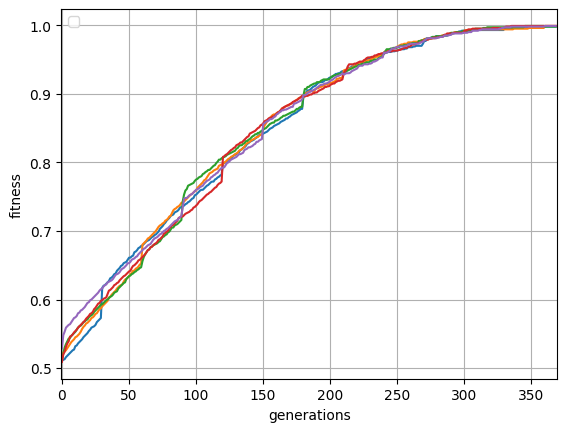

In [21]:
population = None
islands = None
fitness = None

tabu = TabuCache(size=TABU_LENGHT)
hit = True
# prev_best_fitness = 0
# delta_improv_fitness = sys.maxsize 
# mutation_probability = MUTATION_PROBABILITY
xover_probability = XOVER_PROBABILITY
# threshold_improvement = THRESHOLD_IMPROVEMENT
# n_cut_points = MIN_CUT_POINTS

# for the graphs
x = np.linspace(0, MAX_GENERATIONS, MAX_GENERATIONS)
y = [np.zeros(MAX_GENERATIONS) for _ in range(ISLANDS)]
stop = MAX_GENERATIONS

for idx, inst in enumerate(INSTANCES):
    print(f"Solving for instance: {inst}")

    # for plotting
    stop = MAX_GENERATIONS

    # generate population for new problem instances
    population, fitness = generate_population()
    islands = generate_islands(population)

    for gen in tqdm(range(MAX_GENERATIONS)):
        
        # migrations
        if gen != 0 and gen % MIGRATION_RATE == 0:
            migrants = []
            for isl in range(ISLANDS):
                migrants.append(islands[isl][:MIGRANTS])

            # circular migration
            for isl in range(ISLANDS):
                if isl == ISLANDS- 1:
                    islands[0][:MIGRANTS] = migrants[isl]
                else:
                    islands[isl + 1][:MIGRANTS] = migrants[isl]
        
        for isl in range(ISLANDS):
            offsprings = list()

            for _ in range(OFFSPRINGS):
                hit = True
                while hit:
                    p1 = select_parent(islands[isl])
                    p2 = select_parent(islands[isl])
                    o = deepcopy(p1)

                    # if rnd.random() < xover_probability:
                    #     o = n_cut_xover(p1, p2, rnd.choice([k for k in range(n_cut_points)]))
                    #     if rnd.random() < mutation_probability:
                    #         mutation(o)
                    # else: 
                    #     mutation(o)

                    if rnd.random() < xover_probability:
                        o = n_cut_xover(p1, p2, rnd.choice([k for k in range(MAX_CUT_POINTS)]))
                    else: 
                        o = one_cut_xover(p1, p2)

                    mutation(o)
                    
                    hit = tabu.tabu_add(o)

                offsprings.append(o)

            for o in offsprings:
                o.fitness = fitness[idx](o.genotype)
                # o.fitness = fitness[idx].onemax(o.genotype) / LOCI_GENOMES

            islands[isl].extend(offsprings)
            islands[isl].sort(key=lambda i: i.fitness, reverse=True)
            islands[isl] = islands[isl][:POPULATION_SIZE]

            if islands[isl][0].fitness == 1:
                stop = gen

            # updating graph
            y[isl][gen] = islands[isl][0].fitness

            # print(f"Best individual of the generation: {population[idx][0].fitness}")

            # delta = population[idx][0].fitness - prev_best_fitness
            # prev_best_fitness = population[idx][0].fitness

            # if threshold_improvement > 1/OFFSPRINGS and delta < threshold_improvement:
            #     n_cut_points *= 2 
            #     if n_cut_points > MAX_CUT_POINTS:
            #         n_cut_points = MAX_CUT_POINTS
            #     threshold_improvement *= .1
            #     xover_probability *= SCALING_FACTOR_PROB
            #     mutation_prbability = 1 - xover_probability

        if stop != MAX_GENERATIONS:
            print(f"Reached fitness maximum before {MAX_GENERATIONS} generations!")
            break
    
    print(f"Number of fitness calls for instance {inst}: {fitness[idx].calls}")
    plt.figure()
    plt.grid()
    plt.xlabel('generations')
    plt.ylabel('fitness')
    plt.xlim(-0.5, stop + 0.5)

    for isl in range(ISLANDS):
        plt.plot(x[:stop], y[isl][:stop], label=f"island {isl}")

    plt.legend()
    plt.savefig(f"instance{inst}.png")
